### Михаил Ховричев

Будем составлять программу и проводить анализ по ходу действия. В этом блокноте анализируется текст второй главы "Алисы в стране чудес". В аналогичном блокноте -- анализ текста по выбору.

Python 3.4
Для токенизации используется NLTK. Сегментацию он тоже осуществляет, но качество сегментации оставило желать лучшего.
Морфологический анализатор: pymorphy2.
Для построения графиков: matplotlib.

Часть комментариев для удобства будет в самом коде.

In [9]:
%matplotlib inline
import pymorphy2
from nltk import word_tokenize, sent_tokenize
from collections import Counter
import matplotlib.pyplot as plt
from pprint import pprint

morph = pymorphy2.MorphAnalyzer()

Функция для быстрого построения столбчатых диаграмм с нормализацией (высота столбца -- проценты)

In [4]:
def barchart(dic, normalizer, title):
    plt.bar(range(len(dic)), sorted([100*x/normalizer for x in list(dic.values())], reverse=True), width=0.8, color='g')
    plt.xticks(range(len(dic)), sorted(dic, key=dic.get, reverse=True), rotation=45)
    plt.title(title)
    plt.show()

In [5]:
text = open('alice.txt', 'r')
string = text.read()

In [6]:
tokens = word_tokenize(string)

Список токенов выглядит примерно так:

In [57]:
pprint(tokens[:10])

['—', 'Всё', 'страньше', 'и', 'страньше', '!', '—', 'вскричала', 'Алиса', '.']


In [10]:
# Уберём знаки пунктуации и неразобранные токены, остальное выглядит примерно так
words = [morph.parse(token)[0] for token in tokens if not ('PNCT' in morph.parse(token)[0].tag or 'UNKN' in morph.parse(token)[0].tag)]
words[:10]

[Parse(word='всё', tag=OpencorporaTag('ADJF,Apro neut,sing,nomn'), normal_form='весь', score=0.4, methods_stack=((<DictionaryAnalyzer>, 'всё', 703, 14),)),
 Parse(word='страньше', tag=OpencorporaTag('COMP'), normal_form='странний', score=0.5135135135135136, methods_stack=((<DictionaryAnalyzer>, 'раньше', 2648, 27), (<UnknownPrefixAnalyzer>, 'ст'))),
 Parse(word='и', tag=OpencorporaTag('CONJ'), normal_form='и', score=0.997671, methods_stack=((<DictionaryAnalyzer>, 'и', 20, 0),)),
 Parse(word='страньше', tag=OpencorporaTag('COMP'), normal_form='странний', score=0.5135135135135136, methods_stack=((<DictionaryAnalyzer>, 'раньше', 2648, 27), (<UnknownPrefixAnalyzer>, 'ст'))),
 Parse(word='вскричала', tag=OpencorporaTag('VERB,perf,intr femn,sing,past,indc'), normal_form='вскричать', score=1.0, methods_stack=((<DictionaryAnalyzer>, 'вскричала', 950, 2),)),
 Parse(word='алиса', tag=OpencorporaTag('NOUN,anim,femn,Name sing,nomn'), normal_form='алиса', score=1.0, methods_stack=((<DictionaryAnaly

#### Общестатистические характеристики

Посчитаем количество словоупотреблений и словоформ:

In [58]:
wordforms = [item.word for item in words]
unique_wordforms = {word: len(word) for word in wordforms} # На всякий случай будем хранить ещё и длину
print('Количество словоупотреблений:', len(wordforms))
print('Количество словоформ:', len(unique_wordforms))

Количество словоупотреблений: 1590
Количество словоформ: 804


#### Морфологические характеристики

Узнаем процент различных частей речи:

[('NOUN', 320), ('VERB', 257), ('CONJ', 191), ('NPRO', 179), ('PREP', 150)]


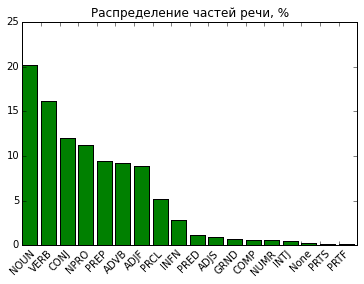

In [61]:
poscounter = Counter([word.tag.POS for word in words])
print(poscounter.most_common(5)) # 5 самых популярных частей речи
barchart(poscounter, len(wordforms), "Распределение частей речи, %")

**Важно!**
В pymorphy2 несколько другая классификация частей речи. Например, инфинитив -- отдельная от глагола часть речи. Краткие и полные прилагательные также относятся к различным частям речи. 

Полный список см. <a href="https://pymorphy2.readthedocs.io/en/latest/user/grammemes.html">здесь</a> и  <a href="http://opencorpora.org/dict.php?act=gram">здесь</a>.

Похожим образом узнаем абсолютную и относительную частоту падежей у существительных:

[('nomn', 118), ('gent', 76), ('accs', 53)]


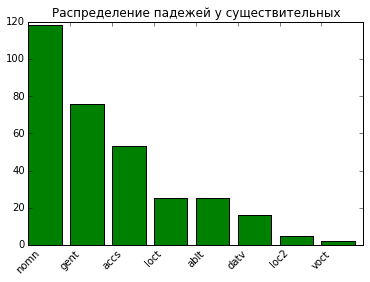

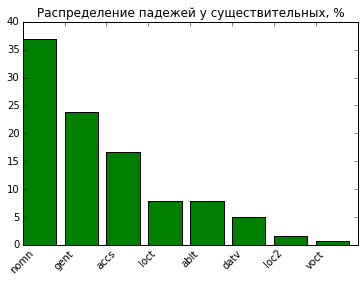

In [14]:
nouncase = Counter([word.tag.case for word in words if word.tag.POS=='NOUN'])
print(nouncase.most_common(3))
barchart(nouncase, 100, "Распределение падежей у существительных")
barchart(nouncase, poscounter['NOUN'], "Распределение падежей у существительных, %")

Видим, что наиболее частотны номинатив, генетив и аккузатив.

То же, с прилагательными (полными):

[('nomn', 69), ('gent', 38), ('accs', 10)]


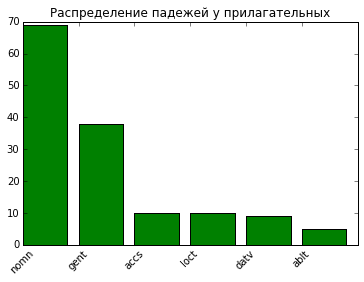

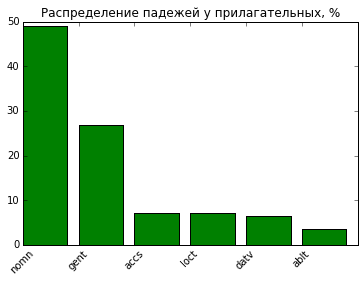

In [15]:
adjcase = Counter([word.tag.case for word in words if word.tag.POS=='ADJF'])
print(adjcase.most_common(3))
barchart(adjcase, 100, "Распределение падежей у прилагательных")
barchart(adjcase, poscounter['ADJF'], "Распределение падежей у прилагательных, %")

Снова лидируют номинатив, генетив и аккузатив.
Неужели это со всеми частями речи (у которых можно выделить падеж)? Проверим.

[('nomn', 298), ('gent', 139), ('accs', 77)]


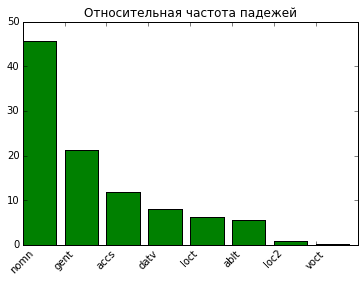

In [16]:
casecounter = Counter([word.tag.case for word in words if word.tag.case is not None])
print(casecounter.most_common(3))
barchart(casecounter, len([word.tag.case for word in words if word.tag.case is not None]), "Относительная частота падежей")

Да, эти три падежа -- самые популярные.

Выясним наиболее частотные морфологические формы глаголов (по общей форме, и по времени/лицу/числу в отдельности):

In [62]:
verbs = [word for word in words if word.tag.POS=='VERB']
verbstags = Counter([verb.tag.cyr_repr for verb in verbs]) #Демонстрация возможностей использования русскоязычных граммем
verbstenses = Counter([verb.tag.tense for verb in verbs])
verbsperson = Counter([verb.tag.person for verb in verbs])
verbsnumber = Counter([verb.tag.number for verb in verbs])

In [63]:
pprint(verbstags.most_common(3))

[('ГЛ,сов,неперех жр,ед,прош,изъяв', 51),
 ('ГЛ,сов,перех жр,ед,прош,изъяв', 39),
 ('ГЛ,несов,неперех жр,ед,прош,изъяв', 16)]


Заметим, что лидирует женский род (обусловлено спецификой текста, главные герои текста -- женского пола), прошедшее время.

Теперь для каждой характеристики отдельно:

In [19]:
pprint(verbstenses.most_common())

[('past', 155), ('futr', 47), ('pres', 45), (None, 10)]


In [20]:
pprint(verbsperson.most_common())

[(None, 167), ('3per', 48), ('1per', 30), ('2per', 12)]


Заметим, что в большинстве глаголов лицо не определилось.

In [21]:
pprint(verbsnumber.most_common())

[('sing', 221), ('plur', 36)]


Глаголов в ед.ч, очевидно, больше.

#### Лексические характеристики

Подсчитаем число уникальных лемм, для каждой будем хранить часть речи. Здесь объединим инфинитивы и глаголы.

In [68]:
lemmas = [[word.normal_form, word.tag.POS] for word in words]

for tuple in lemmas:
    if tuple[1]=='INFN':
        tuple[1]='VERB'
    

lemmas = [(elem[0], elem[1]) for elem in lemmas]
lemmas = list(set(lemmas))
print("Число уникальных лемм:", len(lemmas))
print("Число уникальных лемм существительных:", len([lemm for lemm in lemmas if lemm[1]=='NOUN']))
print("Число уникальных лемм глаголов:", len([lemm for lemm in lemmas if lemm[1]=='VERB']))
print("Число уникальных лемм прилагательных:", len([lemm for lemm in lemmas if lemm[1]=='ADJF']))
print("Число уникальных лемм наречий:", len([lemm for lemm in lemmas if lemm[1]=='ADVB']))
print("Число незнакомых слов:", len([lemm for lemm in lemmas if lemm[1]==None]))

Число уникальных лемм: 643
Число уникальных лемм существительных: 178
Число уникальных лемм глаголов: 181
Число уникальных лемм прилагательных: 60
Число уникальных лемм наречий: 86
Число незнакомых слов: 4


"Незнакомыми словами" назовём слова с неопределённой частью речи. Таких четыре, это слова фразы "— Où est ma chatte?"

Теперь узнаем самые частотные слова и их относительную частоту в процентах (с точностью 5 знаков после запятой)

In [26]:
wordscounter = Counter([word for word in wordforms])
pprint([(w,round(100*f/len(wordforms), 5)) for (w,f) in wordscounter.most_common(10)])

[('и', 3.89937),
 ('она', 2.83019),
 ('в', 2.7044),
 ('я', 2.07547),
 ('не', 2.07547),
 ('алиса', 1.8239),
 ('что', 1.44654),
 ('а', 1.25786),
 ('на', 1.19497),
 ('мышь', 0.8805)]


То же для существительных:

In [43]:
nouncounter = Counter([word.word for word in words if word.tag.POS=='NOUN'])
pprint([(w,round(100*f/poscounter['NOUN'], 5)) for (w,f) in nouncounter.most_common(5)])

[('алиса', 9.0625),
 ('мышь', 4.375),
 ('случае', 1.5625),
 ('кошек', 1.5625),
 ('мейбл', 1.25)]


Для прилагательных:

In [44]:
adjcounter = Counter([word.word for word in words if word.tag.POS=='ADJF'])
pprint([(w,round(100*f/poscounter['ADJF'], 5)) for (w,f) in adjcounter.most_common(5)])

[('всё', 6.38298),
 ('её', 4.25532),
 ('такая', 2.83688),
 ('всех', 2.12766),
 ('всяком', 2.12766)]


Да, pymorphy2 считает все эти слова за прилагательные. Даёт им тег "Местоимённое прилагательное".

То же у глаголов:

In [51]:
verbcounter = Counter([word.word for word in words if (word.tag.POS=='VERB' or word.tag.POS=='INFN')])
pprint([(w,round(100*f/(poscounter['VERB']+poscounter['INFN']), 5)) for (w,f) in verbcounter.most_common(5)])

[('сказала', 3.32226),
 ('была', 2.99003),
 ('подумала', 2.65781),
 ('будет', 2.32558),
 ('было', 1.99336)]


И наречий:

In [53]:
adverbcounter = Counter([word.word for word in words if word.tag.POS=='ADVB'])
pprint([(w,round(100*f/poscounter['ADVB'], 5)) for (w,f) in adverbcounter.most_common(5)])

[('теперь', 5.47945),
 ('тут', 4.79452),
 ('совсем', 4.79452),
 ('сегодня', 2.73973),
 ('здесь', 2.73973)]


Коэффициент лексического разнообразия (lexical diversity): 

In [56]:
LD = len(lemmas)/len(wordforms)
print(round(LD,5))

0.4044


Таким образом, было подсчитано порядка 16 характеристик текста.